<a href="https://colab.research.google.com/github/kamalsnair/Assignment/blob/main/Exit_Test_AI_ML_Pneumonia_detection_Kamal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Problem Statement
The 7 hills group of hospitals wants to bring in automation using artificial intelligence
on X-rays in covid time. Pneumonia Detection is a binary classification problem
where the goal is to classify chest X-ray images as either having pneumonia or not.
The dataset for the competition contains over 26,000 chest X-ray images labeled as
normal or pneumonia.
you need to create a machine learning model that can accurately classify the chest Xray images as normal or pneumonia. The evaluation metric for the competition is the
average precision score, which is a measure of how well the model can identify
positive cases (pneumonia) while minimizing false positives (normal cases classified
as pneumonia).
Several deep learning models, such as convolutional neural networks (CNNs), can be
use to solve this problem. To get started, you can explore the dataset, pre-process
the images, and try building and training different models. 

Importing Required Libraries

In [1]:
import os


In [2]:
pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import gc
import glob
import os
import cv2
import pydicom
import warnings
warnings.simplefilter(action = 'ignore')

Specifing the Data Path in Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
Train_labels = pd.read_csv('/content/drive/MyDrive/EXIT Test AI ML/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')
Train_labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [6]:
train_labels = Train_labels.groupby('Target').size()
train_labels

Target
0    20672
1     9555
dtype: int64

In [7]:
Train_labels.shape

(30227, 6)

<Axes: xlabel='Target'>

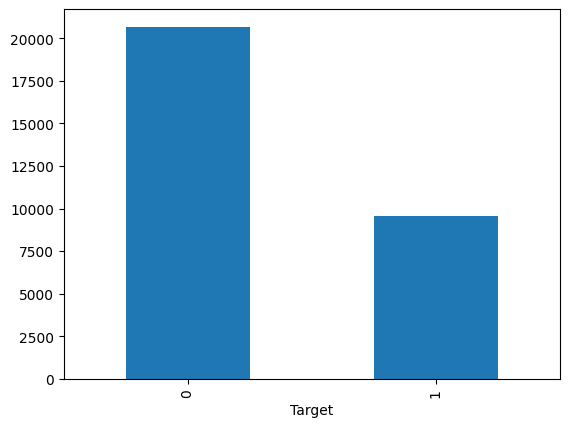

In [8]:
train_labels.plot.bar()

In [9]:
Train_labels.fillna(0.0)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,0.0,0.0,0.0,0.0,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,0.0,0.0,0.0,0.0,0
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1


In [11]:
sample = pd.read_csv('/content/drive/MyDrive/EXIT Test AI ML/rsna-pneumonia-detection-challenge/stage_2_sample_submission.csv')
sample.head()

,patientId,PredictionString
0,0000a175-0e68-4ca4-b1af-167204a7e0bc,0.5 0 0 100 100
1,0005d3cc-3c3f-40b9-93c3-46231c3eb813,0.5 0 0 100 100
2,000686d7-f4fc-448d-97a0-44fa9c5d3aa6,0.5 0 0 100 100
3,000e3a7d-c0ca-4349-bb26-5af2d8993c3d,0.5 0 0 100 100
4,00100a24-854d-423d-a092-edcf6179e061,0.5 0 0 100 100


In [14]:
class_info = pd.read_csv('/content/drive/MyDrive/EXIT Test AI ML/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv')
class_info.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [15]:
class_info.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [16]:
Class_info = class_info.groupby('class').size()
Class_info

class
Lung Opacity                     9555
No Lung Opacity / Not Normal    11821
Normal                           8851
dtype: int64

In [17]:
df = pd.concat([Train_labels,class_info["class"]],axis=1,sort=False)
# df = pd.merge(left = detailed_df, right = train_df, how = 'left', on = 'patientId')
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 30226
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
 6   class      30227 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.8+ MB


In [18]:
df.shape

(30227, 7)

In [19]:
df.isnull().sum()

patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
class            0
dtype: int64

Distribution of classes

In [21]:
df.groupby('class').size()

class
Lung Opacity                     9555
No Lung Opacity / Not Normal    11821
Normal                           8851
dtype: int64

<Axes: ylabel='class'>

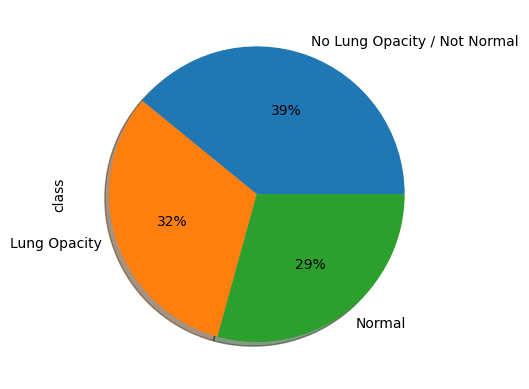

In [20]:
df["class"].value_counts().plot(kind='pie',autopct='%1.0f%%', shadow=True, subplots=False)

In [22]:
pd.pivot_table(df,index=["Target"], aggfunc='count')

,class,height,patientId,width,x,y
Target,,,,,,
0,20672,0,20672,0,0,0
1,9555,9555,9555,9555,9555,9555


<Axes: xlabel='class', ylabel='count'>

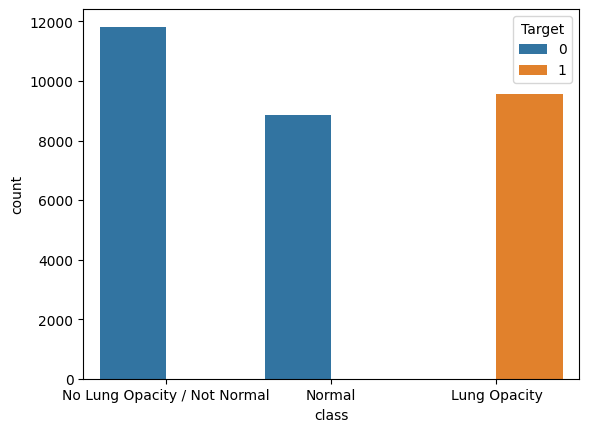

In [23]:
sns.countplot(x = 'class', hue = 'Target', data = df)

Correlation between the variables There is a strong Correlation between height and width variables

In [24]:
df.corr()

,x,y,width,height,Target
x,1.000000,0.007604,-0.058665,0.008256,NaN
y,0.007604,1.000000,-0.299897,-0.645369,NaN
width,-0.058665,-0.299897,1.000000,0.597461,NaN
height,0.008256,-0.645369,0.597461,1.000000,NaN
Target,NaN,NaN,NaN,NaN,1.0


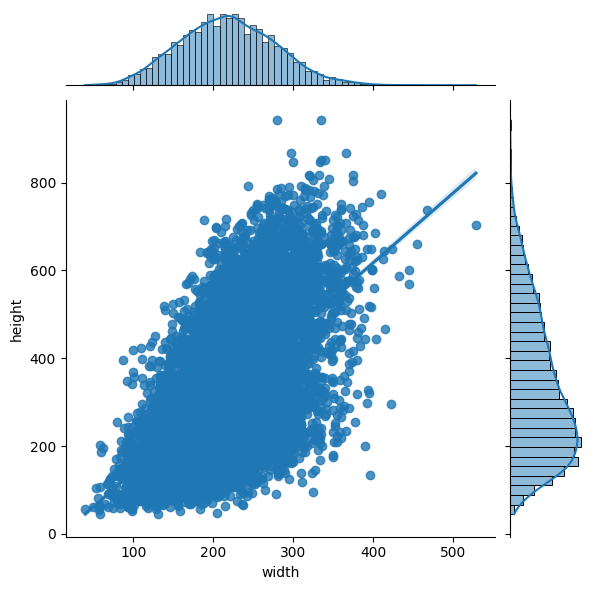

In [25]:
sns.jointplot(x = 'width', y = 'height', data = df, kind="reg")

EDA with the header values from the dataframe

In [27]:
import pydicom
patientId = Train_labels['patientId'][0]
dcm_file = '../content/drive/MyDrive/EXIT Test AI ML/rsna-pneumonia-detection-challenge/stage_2_train_images/%s.dcm'% patientId
dcm_data = pydicom.read_file(dcm_file)

print(dcm_data)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [28]:
dicom_df=df
dicom_df.shape

(30227, 7)

In [30]:
from tqdm import tqdm
def process_dicom_data(data_df):
    for n, pid in tqdm(enumerate(data_df['patientId'].unique())):        
        dcm_file = '/content/drive/MyDrive/EXIT Test AI ML/rsna-pneumonia-detection-challenge/stage_2_train_images/%s.dcm' % pid
        dcm_data = pydicom.read_file(dcm_file)        
        idx = (data_df['patientId']==dcm_data.PatientID)
        data_df.loc[idx,'Modality'] = dcm_data.Modality
        data_df.loc[idx,'PatientAge'] = pd.to_numeric(dcm_data.PatientAge)
        data_df.loc[idx,'PatientSex'] = dcm_data.PatientSex
        data_df.loc[idx,'BodyPartExamined'] = dcm_data.BodyPartExamined
        data_df.loc[idx,'ViewPosition'] = dcm_data.ViewPosition
        
    return data_df

In [ ]:
dicom_df = process_dicom_data(dicom_df)

7563it [1:22:59,  1.38it/s]

In [ ]:
dicom_df = dicom_df.astype({"PatientAge": int})
dicom_df.fillna(0.0, inplace=True)
dicom_df.head()

In [ ]:
dicom_df.nunique()

Now Visualizing the data along with their dicom header values

In [ ]:
plt.figure(figsize = (30, 10))
sns.countplot(x = 'PatientAge', hue = 'Target', data = dicom_df)

In [ ]:
sns.countplot(x = 'PatientSex', hue = 'Target', data = dicom_df)

In [ ]:
sns.countplot(x = 'ViewPosition', hue = 'Target', data = dicom_df);

In [ ]:
dicom_df = dicom_df.drop('Target', axis=1)

In [ ]:
dicom_df['PatientSex'].astype('category')
dicom_df['ViewPosition'].astype('category')
dicom_df['PatientSex'] = np.where(dicom_df["PatientSex"].str.contains("M"), 1, 0)
dicom_df['ViewPosition'] = np.where(dicom_df["ViewPosition"].str.contains("AP"), 1, 0)

In [ ]:
dicom_df.head()

In [ ]:
dicom_df.corr()

Visualizing the dicom images

In [ ]:
def show_dicom_image(data_df):
        img_data = list(data_df.T.to_dict().values())
        f, ax = plt.subplots(2,2, figsize=(16,18))
        for i,data_row in enumerate(img_data):
            pid = data_row['patientId']
            dcm_file = '/content/drive/MyDrive/EXIT Test AI ML/rsna-pneumonia-detection-challenge/stage_2_train_images/%s.dcm' % pid
            dcm_data = pydicom.read_file(dcm_file)                    
            ax[i//2, i%2].imshow(dcm_data.pixel_array, cmap=plt.cm.bone)
            ax[i//2, i%2].set_title('ID: {}\n Age: {} Sex: {}'.format(
                data_row['patientId'],dcm_data.PatientAge, dcm_data.PatientSex))

In [ ]:
show_dicom_image(df[df['Target']==1].sample(n=4))

Showing some random dicom images of a patient who do not have Pnuemonia, however with class No Lung Opacity / Not Normal

In [ ]:
show_dicom_image(df[ (df['Target']==0) & (df['class']=='No Lung Opacity / Not Normal')].sample(n=4))

Showing some random dicom images of a patients who do not have Pnuemonia, however with class Normal

In [ ]:
show_dicom_image(df[ (df['Target']==0) & (df['class']=='Normal')].sample(n=4))

Now displaying images with bounding boxes

In [ ]:
def show_dicome_with_boundingbox(data_df):
    img_data = list(data_df.T.to_dict().values())
    f, ax = plt.subplots(2,2, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        pid = data_row['patientId']
        dcm_file = '/content/drive/MyDrive/EXIT Test AI ML/rsna-pneumonia-detection-challenge/stage_2_train_images/%s.dcm' % pid
        dcm_data = pydicom.read_file(dcm_file)                    
        ax[i//2, i%2].imshow(dcm_data.pixel_array, cmap=plt.cm.bone)
        ax[i//2, i%2].set_title('ID: {}\n Age: {} Sex: {}'.format(
                data_row['patientId'],dcm_data.PatientAge, dcm_data.PatientSex))
        rows = data_df[data_df['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())        
        for j, row in enumerate(box_data):            
            x,y,width,height = row['x'], row['y'],row['width'],row['height']
            rectangle = Rectangle(xy=(x,y),width=width, height=height, color="red",alpha = 0.1)
            ax[i//2, i%2].add_patch(rectangle)   

In [ ]:
show_dicome_with_boundingbox(df[df['Target']==1].sample(n=4))

Model Building

In [ ]:
import os
import csv
import random
import pydicom
import numpy as np
import pandas as pd
from skimage import measure
from skimage.transform import resize
import matplotlib.patches as patches
import tensorflow as tf
from tensorflow import keras

In [ ]:
pneumonia_locations = {}
# load table
with open(os.path.join('/content/drive/MyDrive/EXIT Test AI ML/rsna-pneumonia-detection-challenge/stage_2_train_images'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

Load image filenames

In [ ]:
# load and shuffle filenames
folder = '/content/drive/MyDrive/EXIT Test AI ML/rsna-pneumonia-detection-challenge/stage_2_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 8000
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

Data generator

The dataset is too large to fit into memory, so we need to create a generator that loads data on the fly.

The generator takes in some filenames, batch_size and other parameters.

The generator outputs a random batch of numpy images and numpy masks.

In [ ]:
class generator(keras.utils.Sequence):    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=256, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in self.pneumonia_locations:
            # loop through pneumonia
            for location in self.pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [ ]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    #print(y_true)
    y_true=tf.cast(y_true, tf.float32)
    y_pred=tf.cast(y_pred, tf.float32)
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
   
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
BATCH_SIZE = 128
IMAGE_SIZE = 128

In [ ]:
model = create_network(input_size=IMAGE_SIZE, channels=32, n_blocks=2, depth=4)
model.compile(optimizer='adam', loss=iou_bce_loss, metrics=['accuracy', mean_iou])

# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.0001
    epochs = 3
    return lr*(np.cos(np.pi*x/epochs)+1.)/2


learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

# create train and validation generators
folder = '/content/drive/MyDrive/EXIT Test AI ML/rsna-pneumonia-detection-challenge/stage_2_train_images'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=False, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=False)

print(model.summary())

Plot Accuracy / Loss

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()


Predict test images

In [ ]:
i=0
for imgs, msks in valid_gen:    
    # predict batch of images
    preds = model.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        i=i+1
        #exit after 32 images
        if i>32:
            break
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    # only plot one batch
    break


In [ ]:
folder = '/content/drive/MyDrive/EXIT Test AI ML/rsna-pneumonia-detection-challenge/stage_2_test_images'
test_filenames = os.listdir(folder)
print('n test samples:', len(test_filenames))

# create test generator with predict flag set to True
test_gen = generator(folder, test_filenames, None, batch_size=100, image_size=128, shuffle=False, predict=True)

# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in tqdm(test_gen):
    # predict batch of images
    preds = model.predict(imgs)
    # loop through batch
    for pred, filename in zip(preds, filenames):
        # resize predicted mask
        pred = resize(pred, (1024, 1024), mode='reflect')
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            # proxy for confidence score
            conf = np.mean(pred[y:y+height, x:x+width])
            # add to predictionString
            predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString
    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break

# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']
sub.to_csv('submission.csv')

In [ ]:
# load and shuffle filenames
#folder = '../input/stage_2_test_images'
#test_filenames = os.listdir(folder)
#print('n test samples:', len(test_filenames))

# create test generator with predict flag set to True

folder = '/content/drive/MyDrive/EXIT Test AI ML/rsna-pneumonia-detection-challenge/stage_2_test_images'
#train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=True, predict=False)
#test_gen = generator(folder, valid_filenames, None, batch_size=32, image_size=IMAGE_SIZE, shuffle=False, predict=True)
test_gen = generator(folder, test_filenames, None, batch_size=32, image_size=128, shuffle=False, predict=True)

# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # loop through batch
    for pred, filename in zip(preds, filenames):
       # print(filename)
        # resize predicted mask
        pred = resize(pred, (1024, 1024), mode='reflect')
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            # proxy for confidence score
            conf = np.mean(pred[y:y+height, x:x+width])
            # add to predictionString
            predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString
    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break
        
print("Done predicting...")
        
# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']
sub.to_csv('submission.csv')